# Starbucks Capstone Challenge

### Introduction

The data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Not all users receive the same offer, and that is the challenge to solve with this data set.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 
Note that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Problem Statement

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products. 

- ***The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.***

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('Solarize_Light2')
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, accuracy_score 
from sklearn.model_selection import cross_val_score

# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration

#### 1. Portfolio Dataset

In [2]:
portfolio.head() 

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [6]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [7]:
def bar_plot(df, col_name, plt_title):
    fig, ax = plt.subplots()    
    y = df[col_name].value_counts()
    y.plot(kind='bar')
    plt.title(plt_title)

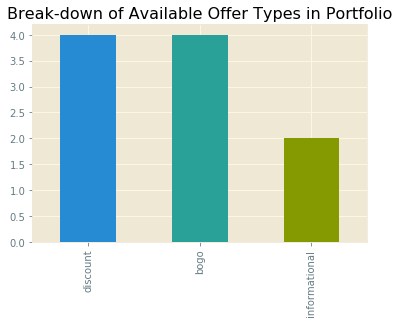

In [8]:
bar_plot(portfolio, 'offer_type', 'Break-down of Available Offer Types in Portfolio')

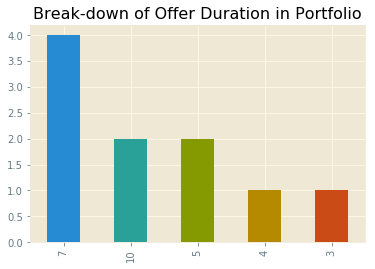

In [9]:
bar_plot(portfolio, 'duration', "Break-down of Offer Duration in Portfolio")

#### 2. Profile Dataset

In [10]:
profile.head() 

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.shape

(17000, 5)

In [12]:
profile.info()
# We can see that there're some null values in gender and income columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [13]:
profile[profile.isna().any(axis=1)].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [14]:
profile[profile['age']== 118].age.count()

2175

In [15]:
profile[profile['age']!= 118].age.value_counts(normalize=True)

58     0.027521
53     0.025093
51     0.024486
59     0.024216
54     0.024216
57     0.023811
52     0.023676
55     0.023609
56     0.023069
63     0.022799
60     0.022462
49     0.021653
62     0.021450
67     0.021383
64     0.020978
61     0.020843
48     0.019427
66     0.019157
50     0.019157
65     0.018887
68     0.017470
70     0.016998
69     0.016324
47     0.015649
45     0.015582
71     0.015514
42     0.015312
43     0.014503
46     0.014300
73     0.014098
         ...   
22     0.008836
30     0.008836
29     0.008702
23     0.008499
35     0.007960
81     0.007960
79     0.007892
80     0.007825
31     0.007622
82     0.007083
83     0.006880
84     0.005599
18     0.004722
85     0.004722
87     0.004452
88     0.004317
86     0.003642
89     0.003575
90     0.003508
91     0.003170
92     0.002698
94     0.002226
93     0.001956
95     0.001484
97     0.000877
100    0.000809
96     0.000540
98     0.000337
101    0.000337
99     0.000337
Name: age, Length: 84, d

There are 2175 customers, whose age is assigned as 118 year, and all of their information is missing, while customer with age different from 118 have data associated with their profile. Age of 118 is definetily an outlier in this data.

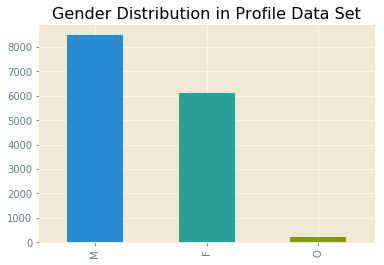

In [16]:
bar_plot(profile, 'gender', "Gender Distribution in Profile Data Set")

In [17]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


#### 3. Transcript Dataset

In [18]:
transcript.head() 

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [19]:
transcript.shape

(306534, 4)

In [20]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
transcript.describe(include='all')

,event,person,time,value
count,306534,306534,306534.000000,306534
unique,4,17000,NaN,5121
top,transaction,94de646f7b6041228ca7dec82adb97d2,NaN,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
freq,138953,51,NaN,14983
mean,NaN,NaN,366.382940,NaN
std,NaN,NaN,200.326314,NaN
min,NaN,NaN,0.000000,NaN
25%,NaN,NaN,186.000000,NaN
50%,NaN,NaN,408.000000,NaN
75%,NaN,NaN,528.000000,NaN


In [22]:
# transcript.value.value_counts()

There're 3 possible values from column `value`: `offer_id`, `amount` and `reward`

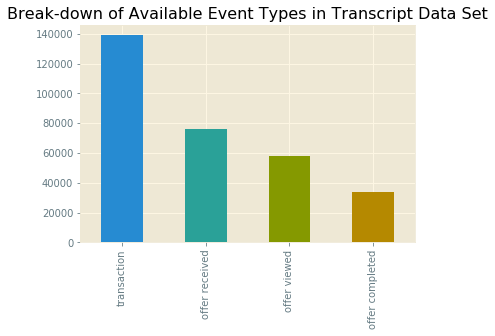

In [23]:
bar_plot(transcript, 'event', "Break-down of Available Event Types in Transcript Data Set")

## Data Cleaning

### 1. Portfolio Data
- Rename columns in order to be able to merge all dataframes later on

In [24]:
portfolio = portfolio.rename(columns={'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'})

In [25]:
portfolio.head(1)

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10


### 2. Profile Data
- Rename columns in order to be able to merge all dataframes later on
- Fill null values: `age` & `income` columns with mean, `gender` - with mode
- People above 80s will be considered as outliers - removed from the dataset
- Create 4 categories for column `age` for analysis: 20-45, 46-60, 61-80

In [26]:
profile = profile.rename(columns={'id':'customer_id', 'income':'customer_income'})

In [27]:
profile.head(1)

,age,became_member_on,gender,customer_id,customer_income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN


In [28]:
def clean_profile(df):
    """
    # Replace age of 118 values (NaN) with mean 
    # Replace income null values with mean
    # Replace gender null values with mode
    # Create 4 categories for column age for analysis: 20-45, 46-60, 61-80
        
    Parameters
    ----------   
    df: a given dataframe
    
    Returns
    -------
    df: cleaned dataframe
    """
    
    df.replace(118, np.nan , inplace=True)
    df['age'] = df['age'].fillna(df['age'].mean())
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    # remove outliers
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    # add age_group column
    df.loc[(df.age < 20) , 'age_group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'age_group'] = '20-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df

In [29]:
cleaned_profile = clean_profile(profile)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [30]:
cleaned_profile.head()

,became_member_on,gender,customer_id,customer_income,age_group
0,20170212,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,46-60
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,46-60
2,20180712,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,46-60
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,61-80
4,20170804,M,a03223e636434f42ac4c3df47e8bac43,65404.991568,46-60


In [31]:
cleaned_profile.isnull().sum()

became_member_on    0
gender              0
customer_id         0
customer_income     0
age_group           0
dtype: int64

### 3. Transcript Data
- Rename columns in order to be able to merge all dataframes later on
- Split column `values` to `offer_id`, `reward` and `amount` columns

In [32]:
transcript = transcript.rename(columns={'person':'customer_id'})

In [33]:
transcript.head(1)

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


In [34]:
def clean_transcript(df):
    """
    Split column values to offer_id, reward and amount columns
    
    Parameters
    ----------   
    df: a given dataframe
    
    Returns
    -------
    df: cleaned dataframe
    
    New column names given for expanded keys
    -------
    money_gained : money gained from "offer completed"
    money_spent : money spent in "transaction"
    offer_id 
    """
    
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['money_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['money_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    # move 'offer id' values into 'offer_id'
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    # drop 'offer id' column 
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    # replace NaN
    df.fillna(0 , inplace=True)
    
    return df

In [35]:
cleaned_transcript = clean_transcript(transcript)

In [36]:
cleaned_transcript.head()

,event,customer_id,time,offer_id,money_gained,money_spent
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [37]:
cleaned_profile.isnull().sum()

became_member_on    0
gender              0
customer_id         0
customer_income     0
age_group           0
dtype: int64

In [38]:
cleaned_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16014 entries, 0 to 16999
Data columns (total 5 columns):
became_member_on    16014 non-null int64
gender              16014 non-null object
customer_id         16014 non-null object
customer_income     16014 non-null float64
age_group           16014 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 750.7+ KB


In [39]:
# Merge dataframes
merged_df = pd.merge(portfolio, cleaned_transcript, on='offer_id')
merged_df = pd.merge(merged_df, cleaned_profile, on='customer_id')

In [40]:
merged_df.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,money_gained,money_spent,became_member_on,gender,customer_income,age_group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,20170909,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,20170909,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,20170909,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,20170909,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,20170909,M,100000.0,61-80


### Exploratory Data Analysis

In [41]:
# What is the average income of customers who use Starbuck's app?
print(round(merged_df['customer_income'].mean(), 2))

65924.49


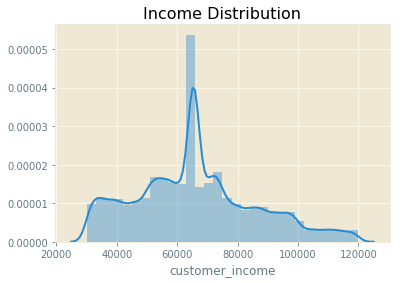

In [42]:
sns.distplot(merged_df['customer_income'], bins=30, hist_kws={'alpha': 0.4});
plt.title('Income Distribution')
plt.show()

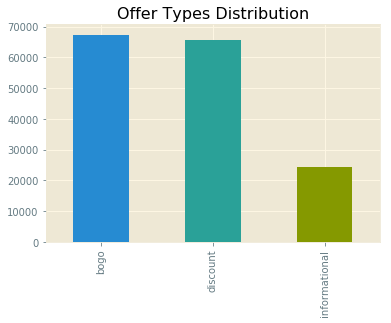

In [43]:
# What offers are the most used by the customers?
merged_df['offer_type'].value_counts().plot.bar(title='Offer Types Distribution')

`bogo` offers have almost the same amount `discount` offers

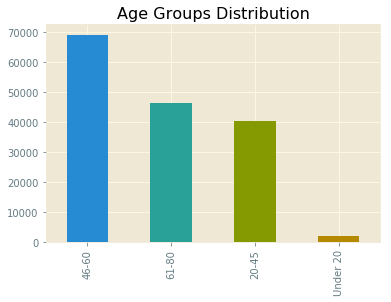

In [44]:
# What is the distribution of customers by their age?
merged_df['age_group'].value_counts().plot.bar(title='Age Groups Distribution')

The largest group of Starbucks apps users are the customers between 46 and 60 years old. It's slightly unexpected, because in general younger generation is tend to use apps more frequently

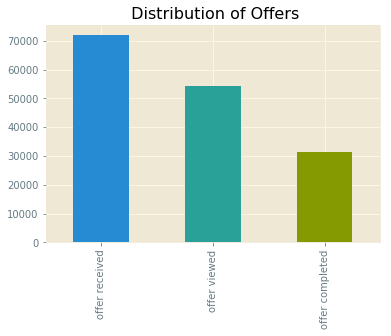

In [45]:
# What actions were made by customers when the offer was received?
merged_df['event'].value_counts().plot.bar(title=' Distribution of Offers')

There is a large group of people who do not pay any attention to the offers. There're more people who receive, view & ignore the offer than the one's who actually complete it.

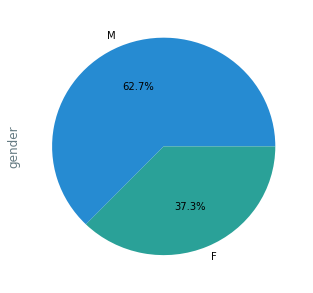

In [46]:
# What is the distribution of males & females between the customers?
gen = merged_df[merged_df['gender'] != 'O']
gen['gender'].value_counts().plot(kind='pie', figsize=(5, 5), autopct='%1.1f%%')

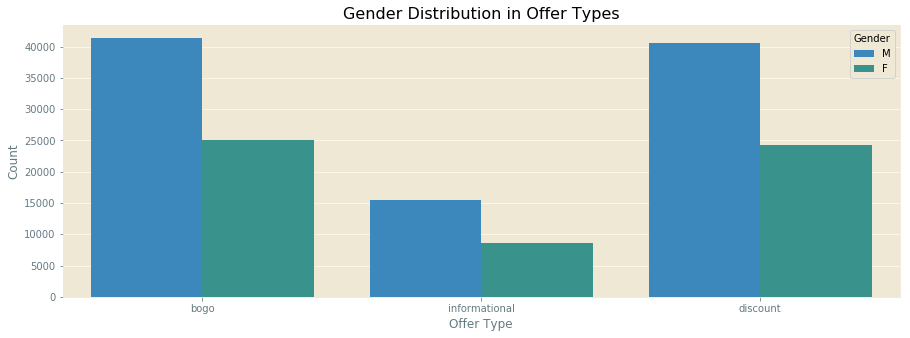

In [47]:
# What is the gender disdribution for each offer type?
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=gen)
plt.title('Gender Distribution in Offer Types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

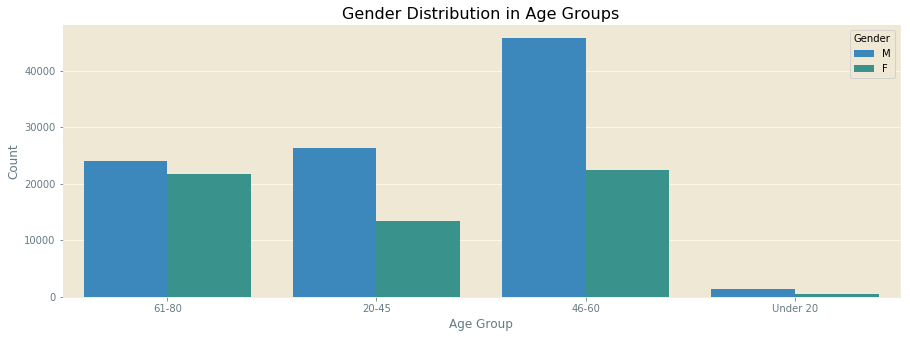

In [48]:
# What is the gender distribution in age groups?

plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", hue= "gender", data=gen)
plt.title('Gender Distribution in Age Groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

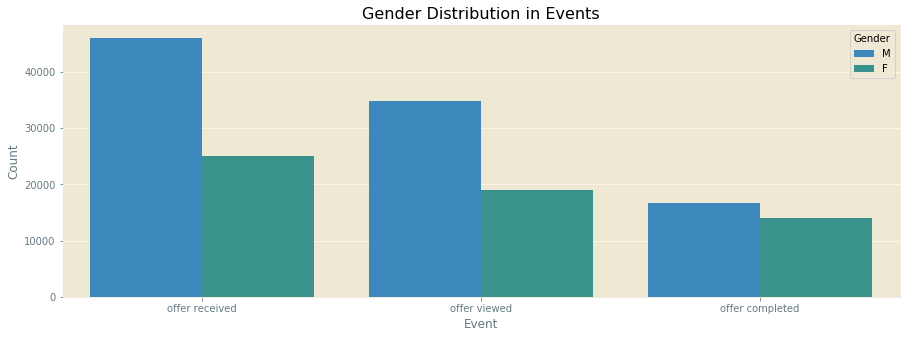

In [49]:
# How males and females reacted to the offers received?
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=gen)
plt.title('Gender Distribution in Events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

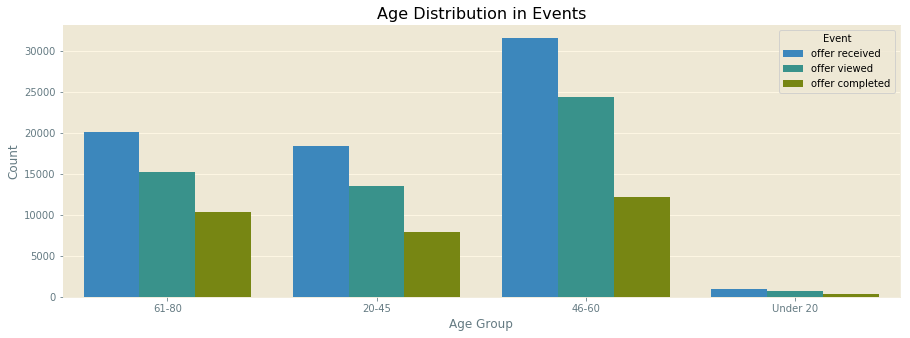

In [50]:
# How different age groups responded to the offers?
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", hue= "event", data=gen)
plt.title('Age Distribution in Events')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Event')

## Modelling Preparation

- Encode `offer_id` and `customer_id` 
- Encode `event` column: 1 - offer received, 2 - offer viewed, 3 - offer completed
- Encode categorical variables: `gender`, `channels`, `offer_type`, `age_group`
- Drop column `became_member_on` and add monthly anr yearly data
- Scale and normalize numerical data

In [51]:
def clean_final_df(df):
    """
    Encode event column: 1 - offer received, 2 - offer viewed, 3 - offer completed
    Encode categorical variables: gender, channels, offer_type, age_group
    Drop column became_member_on and add monthly anr yearly data
    Scale and normalize numerical data
    
    Parameters
    ----------
    df: merged dataframe
    
    Returns
    -------
    df: cleaned dataframe
       
    """
    
    # process 'event' data to numerical values
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    # process categorical variables
    categorical = ['offer_type', 'gender', 'age_group']
    df = pd.get_dummies(df, columns = categorical)
    # process channels column 
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    # process became_member_on column
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    df.drop('became_member_on',axis=1, inplace=True)    
    
    # process numerical variables
    scaler = MinMaxScaler() 
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
    df[numerical] = scaler.fit_transform(df[numerical])
    
    return df

In [52]:
cleaned_df = clean_final_df(merged_df)

In [53]:
# process offer_id column
offer_ids = cleaned_df['offer_id'].unique().tolist()
offer_mapping = dict(zip(offer_ids, range(len(offer_ids))))
cleaned_df.replace({'offer_id': offer_mapping}, inplace=True)
    
# process customer_id column
customer_ids = cleaned_df['customer_id'].unique().tolist()
customer_mapping = dict(zip(customer_ids, range(len(customer_ids))))
cleaned_df.replace({'customer_id': customer_mapping}, inplace=True)

In [54]:
cleaned_df.head()

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,money_gained,money_spent,customer_income,...,age_group_20-45,age_group_46-60,age_group_61-80,age_group_Under 20,email,mobile,social,web,month_member,year_member
0,0.5,0.571429,0,1.0,1,0,0.000000,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
1,0.5,0.571429,0,1.0,2,0,0.142857,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
2,0.5,0.571429,0,1.0,1,0,0.705882,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
3,0.5,0.571429,0,1.0,2,0,0.714286,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
4,0.5,0.571429,0,1.0,3,0,0.714286,1.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017


In [58]:
cleaned_df.shape

(157503, 26)

In [59]:
df = cleaned_df.drop('event', axis=1)

In [60]:
label = cleaned_df['event']

## Modelling

In [63]:
# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size = 0.4, random_state = 0)

In [64]:
print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 94501 rows
Testing set: 63002 rows


### Metrics

In order to evaluate how good the model is, the F1 score will be calculated. The F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. The F1 score is primarily used to compare the performance of two classifiers, for example, suppose that classifier A has a higher recall, and classifier B has higher precision. The closer the score is to 100, the better the model.

In [67]:
def train_test(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
    """
    train_predictions =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_predictions) * 100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro') * 100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

For this analysis, three classifiers are built: KNeighborsClassifier as a benchmark to evaluate the F1 score metric in comparison to other two classifiers: DecisionTreeClassifier and RandomForestClassifier. 

### KNeighborsClassifier

In [96]:
clf_KNeighborsClassifier = KNeighborsClassifier(n_neighbors = 6)
a_train_f1, a_test_f1, a_model = train_test(clf_KNeighborsClassifier)

### DecisionTreeClassifier

In [97]:
clf_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 10)
b_train_f1, b_test_f1, b_model = train_test(clf_DecisionTreeClassifier)

### RandomForestClassifier

In [98]:
clf_RandomForestClassifier = RandomForestClassifier(random_state = 10)
c_train_f1, c_test_f1, c_model = train_test(clf_RandomForestClassifier)

In [99]:
models = {'model': [a_model, b_model, c_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
comparison = pd.DataFrame(models)

In [100]:
comparison

,model,train F1 score,test F1 score
0,KNeighborsClassifier,54.405773,34.214787
1,DecisionTreeClassifier,95.455075,85.098886
2,RandomForestClassifier,94.336568,69.304149


As we can see from the above table both models DecisionTreeClassifier and RandomForestClassifier performed better than KneighborsClassifier. DecisionTreeClassifier got the best score: the train F1 score is 95%  and the test F1 score is 85%, while RandomForestClassifier got 94% of the train F1 score and 69% of the test F1 score. The scores are pretty good to use for the classification purpose to predict whether a customer will respond to an offer.

## Conclusion 

- Males represent 62.7%  and females 37.3% of the customers who use the Starbucks app
- Both males and females in age group from 46 to 60 use the app the most
- The most popular and preferred offer is a discount
- There is a lower number of customers who actually complete the offer as compared to the ones who just view & ignore it
- DecisionTreeClassifier got the highest F1 score in comparison to RandomForestClassifier  and KneighborsClassifier. DecisionTreeClassifier model could be used for the classification purpose to predict whether a customer will respond to an offer


## Improvement

To improve the model’s performance we could run a longer experiment having more customers in our data set. We could collect demographic data, for example, location where one of the Starbucks products has been purchased, scores of drinks reviews, day and at what time the transaction has been made etc. Also, we could also perform A/B testing experiments between similar users in order to see what offers are the most effective. 

## References

- https://learn.udacity.com/nanodegrees/nd025/parts/cd1971/lessons/81217aa8-0633-455b-89ee-0a19bc1563ca/concepts/76d802ca-2deb-4fd0-a707-8dc0e0f3260c
- https://www.educative.io/answers/what-is-the-f1-score
- https://scikit-learn.org/stable/tutorial/index.html
- https://scikit-learn.org/stable/modules/preprocessing.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- https://stackoverflow.com/questions/70322857/convert-list-using-zip-to-dictionary
- https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
